# General

In [2]:

# imports

import os

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit


In [3]:
# Folder paths
origin_folder = os.getcwd()
print(origin_folder)
mes_folder_1 = os.path.join(origin_folder,"kinetics_data","part 1")
mes_folder_2 = os.path.join(origin_folder,"kinetics_data","part 2")
mes_folder_3 = os.path.join(origin_folder,"kinetics_data","part 3")


c:\Users\yaniv\Yehonathan TAU\PhyChemLab


In [4]:
# Functions
def get_data(file_path, cut = [360,1200]):
    '''
    take raw data (.SSM/.ssm) and transform it to pd data frame 
    '''

    fix_file(file_path)
    df = pd.read_csv(file_path, delimiter = '\t', names = ['Wavelength', 'Intensity'], header = 0)
    df2 = df[(cut[0] < df['Wavelength']) & (df['Wavelength'] < cut[1])]
    # df2.reset_index(drop=True, inplace=True)
    return df2

def culc_absorbance(I, I0,A = None):
    '''
    culculate absorbance dataframe from intensity
    '''
    A = pd.DataFrame()
    A['Absorbance'] = -np.log10(I['Intensity']/I0['Intensity'])
    A['Wavelength'] = I['Wavelength']

    return A

def get_concentration(file_name):
    '''
    get concentration from file name
    '''
    return float(file_name.split('_')[0]) # file name is like 0.1_M.SSM


def culc_molar_absorption_coefficient(slope, error, l = 1):
    '''
    culculate molar absorption coefficient from absorbance and concentration
    '''
    return slope / l, error / l

def linear_func(x,a0,a1): # define the modle fucntion - linear
    return a1 * x + a0

def linear_fit(x,y):
    '''
    fit linear function
    '''
    popt, pcov = curve_fit(linear_func, x, y)
    return popt, np.sqrt(np.diag(pcov))


# function for part 3:

def get_episod(file_name):
    '''
    get episod from file name
    '''
    return int(file_name.split('-')[1].split('Ep')[0]) # file name is like sol1-1Ep.SSM

def get_sol_data(sol_num = None, I0 = None):
    '''
    get the absorbans spectra of the solution (numerd sol_num) in all the episods
    '''
    folder_name = 'sol' + str(sol_num)
    absorbance_all3 = pd.DataFrame()
    my_dict = {'Wavelength': np.array(I0['Wavelength'])}
    for file in os.listdir(folder_name):
        if file.endswith(".ssm"):
            I = get_data(os.path.join(folder_name, file))
            absorbance = culc_absorbance(I, I0)
            episod = get_episod(file)
            my_dict[str(episod)] = absorbance['Absorbance']
    
    return pd.DataFrame(my_dict)

def get_sol_data_wavelength(absorbance_all3, total_time, wavelength, epsilon):
    '''
    get the absorbans spectra of the solution (numerd sol_num) in all the episods
    '''
    episod_list = absorbance_all3.columns[1:].astype(int)
    avg_time_interval = total_time / max(episod_list)

    df = pd.DataFrame({'Episod': episod_list})
    df['time'] = avg_time_interval * episod_list
    df['Absorbance'] = absorbance_all3.loc[absorbance_all3['Wavelength'] == wavelength].values[0][1:]
    df['concentration'] = get_concentration_from_absorbance(df['Absorbance'],epsilon, l = 1)
    return df

def get_concentration_from_absorbance(A,epsilon,l = 1):
    return A / (epsilon * l)


def fix_file(file_path):
    '''
    fix the file to be read by pandas
    '''
    with open(file_path, 'r') as file:
        filedata = file.read()

    filedata = filedata.replace('  ', '\t')
    filedata = filedata.replace(' ', '')
    if filedata.split('\n')[1].startswith('"'):
        filedata = '\n'.join(filedata.split('\n')[2:])

    with open(file_path, 'w') as file:
        file.write(filedata)

def get_rate_of_reaction(concentration, time):
    '''
    get the rate of reaction from the concentration and time
    '''


# Part 1:  Beer-Lambert's Law Validation

Current Directory: c:\Users\yaniv\Yehonathan TAU\PhyChemLab\kinetics_data\part 1


c:\Users\yaniv\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\yaniv\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\yaniv\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\yaniv\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\yaniv\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = geta

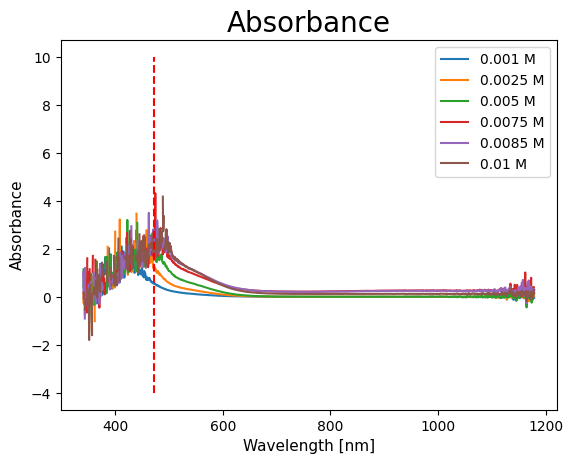

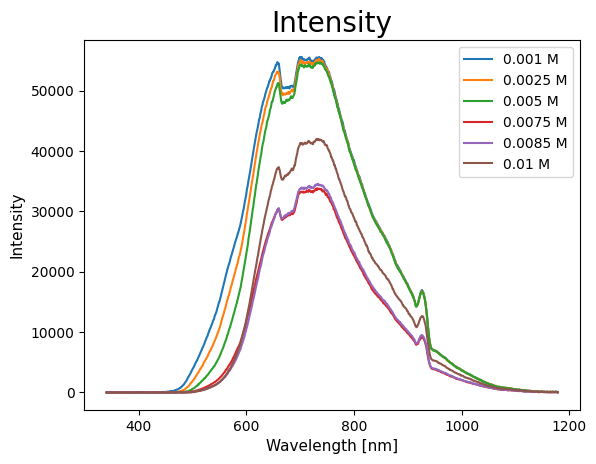

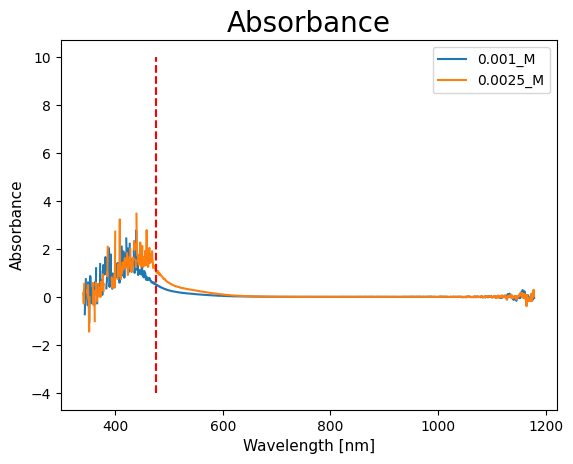

In [57]:
# Change directory to mes_folder_1 if not already there
if os.getcwd() != mes_folder_1:
    os.chdir(mes_folder_1)
print("Current Directory:", os.getcwd())

cut = [300,1200]
# define I0
dark = get_data(r"dark.SSM", cut = cut)
I0 = get_data(r"blank.SSM", cut = cut)
I0['Intensity'] = I0['Intensity'] - dark['Intensity']

# get absobance data frame
Absorbabce_all = pd.DataFrame()
Absorbabce_all['Wavelength'] = I0['Wavelength']

for file in os.listdir('.'):
    if file.endswith(".SSM") and file != 'I0.SSM' and file != 'dark.SSM' and file != 'blank.SSM':
        data = get_data(file, cut = cut)
        data['Intensity'] = data['Intensity'] - dark['Intensity']
        plt.figure(1)
        C = get_concentration(file)
        plt.plot(data['Wavelength'], data['Intensity'], label = str(C) + ' M')
        Absorbabce_all[str(C) + '_M'] = culc_absorbance(data, I0)['Absorbance']
        plt.figure(2)
        plt.plot(Absorbabce_all['Wavelength'], Absorbabce_all[str(C) + '_M'], label = str(C) + ' M')

plt.vlines(472, -4,10, color = 'r', linestyle = '--')
plt.legend()
plt.title('Absorbance', fontsize = 20)
plt.xlabel('Wavelength [nm]', fontsize = 11)
plt.ylabel('Absorbance', fontsize = 11)

plt.figure(1)
plt.legend()
plt.title('Intensity', fontsize = 20)
plt.xlabel('Wavelength [nm]', fontsize = 11)
plt.ylabel('Intensity', fontsize = 11)
plt.show()


# plt.plot(Absorbabce_all['Wavelength'], Absorbabce_all['0.01_M'], label = '0.01_M')
plt.plot(Absorbabce_all['Wavelength'], Absorbabce_all['0.001_M'], label = '0.001_M')
plt.plot(Absorbabce_all['Wavelength'], Absorbabce_all['0.0025_M'], label = '0.0025_M')
plt.vlines(475, -4,10, color = 'r', linestyle = '--')
plt.legend()
plt.title('Absorbance', fontsize = 20)
plt.xlabel('Wavelength [nm]', fontsize = 11)
plt.ylabel('Absorbance', fontsize = 11)
plt.show()
# display(Absorbabce_all)

In [98]:
# change data frame to more readable format

# Create a dictionary to hold the data for each wavelength
data_dict = {'Concentration': [get_concentration(file) for file in os.listdir('.') if file.endswith(".SSM") and file != 'I0.SSM' and file != 'dark.SSM' and file != 'blank.SSM']}
for wavelength in Absorbabce_all['Wavelength']:
    data_dict[str(wavelength)] = Absorbabce_all[Absorbabce_all['Wavelength'] == wavelength].drop(columns='Wavelength').values[0]

# Use pd.concat to join all columns at once
Absorbabce_all2 = pd.concat([pd.DataFrame(data_dict)], axis=1)
# Absorbabce_all2.drop([4,5], inplace=True)
display(Absorbabce_all2)

,Concentration,340.5,341.0,341.5,342.0,342.5,343.0,343.5,344.0,344.5,...,1174.0,1174.5,1175.0,1175.5,1176.0,1176.5,1177.0,1177.5,1178.0,1178.5
0,0.0010,0.906541,NaN,0.120050,0.319074,0.051858,NaN,-0.722634,-0.120574,0.025771,...,-0.155616,-0.145892,-0.089464,-0.076549,-0.117098,-0.102000,-0.046156,-0.041591,-0.044272,-0.038632
1,0.0025,0.148887,0.050970,-0.273111,0.186310,0.544068,NaN,0.698970,inf,NaN,...,-0.113173,-0.172591,0.015305,0.126045,0.049319,0.009651,0.130732,0.298853,0.126495,0.031763
2,0.0050,NaN,1.151997,0.355060,0.751229,0.916454,NaN,0.055517,-0.147897,-0.114081,...,-0.240171,-0.126175,0.039075,0.200817,0.076001,-0.007314,0.163654,0.411236,0.245801,0.149790
3,0.0075,0.610156,NaN,0.221849,0.103589,NaN,NaN,-0.528059,NaN,0.258501,...,-0.046043,0.001102,0.084777,0.287164,0.306950,0.242279,0.299704,0.415760,0.268785,0.174011
4,0.0085,1.022337,0.409758,-0.039152,-0.095899,-0.299146,NaN,-0.899456,1.201645,NaN,...,0.012316,0.054468,0.134616,0.196887,0.178830,0.155336,0.247376,0.347516,0.330388,0.315080
5,0.0100,NaN,NaN,-0.066713,-0.012445,0.187521,NaN,-0.528059,-0.185097,-0.115453,...,-0.038265,-0.024089,0.058970,0.169103,0.088178,0.022254,0.100689,0.229185,0.286448,0.279183


$$
A = - \log \left(I/I_0\right)
$$

$$
A = \varepsilon c l
$$

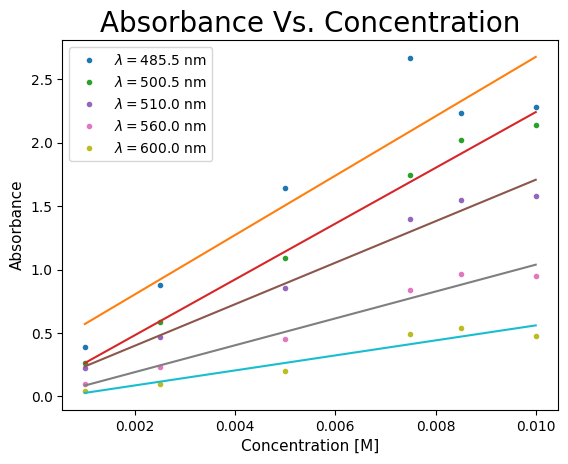

Molar Absorption Coefficients ε [M^-1 cm^-1]:


,wavelength [nm],molar_absorption,molar_absorption_err
0,485.5,233.943829,46.899121
1,500.5,219.783690,10.568171
2,510.0,163.491204,11.726592
3,560.0,105.830257,9.781678
4,600.0,59.146035,9.516953


In [101]:
# Plot the data and extract the molar absorption coefficient for each wavelength

wavelengths_list = [485.5,500.5,510.0,560.0,600.0]
# I0['Wavelength'][500 < I0['Wavelength']].values
#[500.5,510.0,662.5, 740.5] # replace with the wavelengths you want to use
# Absorbabce_all2.drop([3], inplace=True)

l = 1 # in cm - optic path length
if l is None:
    raise ValueError("Optic path length (l) must be defined.")

molar_absorption = {'wavelength [nm]': wavelengths_list, 'molar_absorption': [], 'molar_absorption_err': []}

for wavelength in wavelengths_list:
    # Fit a linear function to the data
    fit = linear_fit(Absorbabce_all2['Concentration'], Absorbabce_all2[str(wavelength)])
    plt.plot(Absorbabce_all2['Concentration'], Absorbabce_all2[str(wavelength)], '.', label= r"$\lambda=$"+ str(wavelength) + ' nm')
    plt.plot(Absorbabce_all2['Concentration'], linear_func(Absorbabce_all2['Concentration'], *fit[0]))

    # Calculate molar absorption coefficient
    epsilon = culc_molar_absorption_coefficient(fit[0][1], fit[1][1], l) # in M^-1 cm^-1
    molar_absorption['molar_absorption'].append(epsilon[0])
    molar_absorption['molar_absorption_err'].append(epsilon[1]) 

plt.legend()
plt.xlabel('Concentration [M]', fontsize=11)
plt.ylabel('Absorbance', fontsize=11)
plt.title('Absorbance Vs. Concentration', fontsize=20)
plt.show()

molar_absorption_df = pd.DataFrame(molar_absorption)
print('Molar Absorption Coefficients ε [M^-1 cm^-1]:')
display(molar_absorption_df)

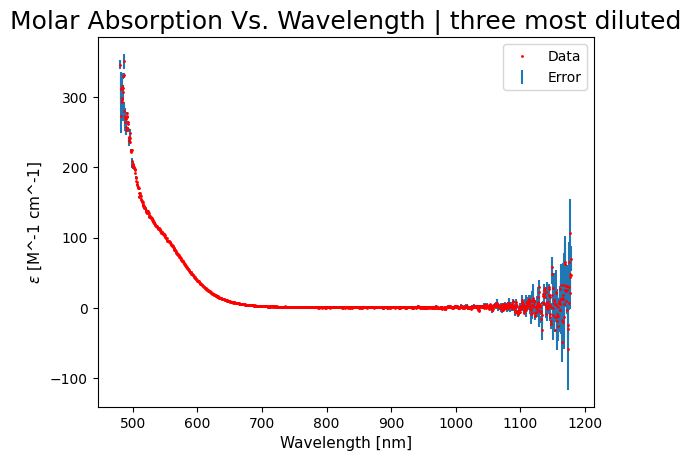

In [96]:
plt.errorbar(molar_absorption_df['wavelength [nm]'], molar_absorption_df['molar_absorption'], yerr=molar_absorption_df['molar_absorption_err'], fmt='none', label = 'Error')
plt.plot(molar_absorption_df['wavelength [nm]'], molar_absorption_df['molar_absorption'], '.', color='r', markersize=2, label='Data')
plt.xlabel('Wavelength [nm]', fontsize=11)
plt.ylabel(r'$\epsilon$ [M^-1 cm^-1]', fontsize = 11)
plt.title('Molar Absorption Vs. Wavelength | three most diluted', fontsize=18)
plt.legend()
plt.show()

# Part 2: Determination of Optimal Acid:Acetone:Iodide Ratio


In [8]:
if os.getcwd() != mes_folder_2:
    os.chdir(mes_folder_2)
print("Current Directory:", os.getcwd())

# define I0
dark = get_data(r"dark.SSM")
I0 = get_data(r"blank.SSM")
I0['Intensity'] = I0['Intensity'] - dark['Intensity']

# find c at wavelength
waveeps = molar_absorption_df[['wavelength [nm]','molar_absorption']].loc[0].values

sol_data = get_sol_data(1, I0)
# display(sol_data)
sold_data_wavelength = get_sol_data_wavelength(sol_data, 370, *waveeps)

# display(sold_data_wavelength)


Current Directory: c:\Users\yaniv\Yehonathan TAU\PhyChemLab\kinetics_data\part 2


c:\Users\yaniv\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\yaniv\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\yaniv\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\yaniv\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\yaniv\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, me

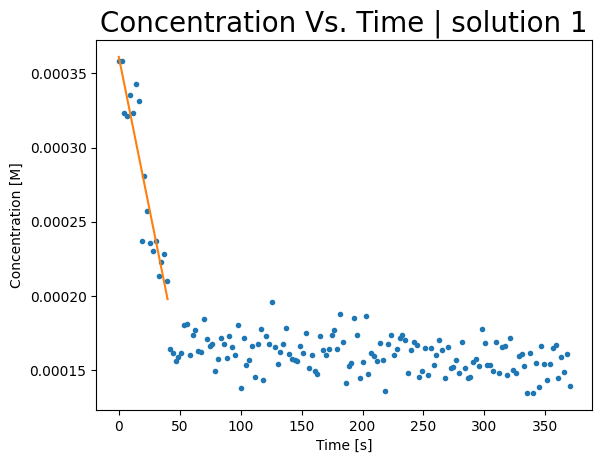

Rate of reaction [M/s]: 4.079e-06 ± 4.219e-07


In [9]:
# get rate of reaction
fit_interval = 40 # in seconds
df_fit = sold_data_wavelength[sold_data_wavelength['time'] < fit_interval]
fit = linear_fit(df_fit['time'], df_fit['concentration'])

# plot the Concentration Vs. time
if True:
    plt.plot(sold_data_wavelength['time'], sold_data_wavelength['concentration'], '.')
    t_show = np.linspace(0, fit_interval, 1000)
    plt.plot(t_show, linear_func(t_show, *fit[0]), label='fit')
    plt.xlabel('Time [s]')
    plt.ylabel('Concentration [M]')
    plt.title('Concentration Vs. Time | solution 1', fontsize=20)
    plt.show()

print('Rate of reaction [M/s]: {:.3e} ± {:.3e}'.format(-fit[0][1], fit[1][1]))

# Part 3: Finding the Reaction Order for Each Component

In [123]:
# soltions initial concentrations table
xl_file_path = r"C:\Users\yaniv\OneDrive - mail.tau.ac.il\Chemical Kinetics.xlsx"
solutions_df = pd.read_excel(xl_file_path,index_col=0, sheet_name='Part 3 - solution')
solutions_df['total_time'] = [235.5,235.6,235.5,261.8,287.3,275.0,275.1,261.5,262.0,274.7] # for sol1 first = 74.9
solutions_df['fit_intervals'] = [150, 150, 100,150, 100, 250,250, 100, 100, 60]
display(solutions_df)
# waveeps = molar_absorption_df[['wavelength [nm]','molar_absorption']].loc[0].values
waveeps = molar_absorption_df[['wavelength [nm]','molar_absorption']][molar_absorption_df['wavelength [nm]'] == 490.5].values[0]

,acetone,I2,HCl,pH,total_time,fit_intervals
solution,,,,,,
1,0.009533,0.00025,0.003054,2.515087,235.5,150
2,0.009533,0.00020,0.003054,2.515087,235.6,150
3,0.009533,0.00015,0.003054,2.515087,235.5,100
4,0.009533,0.00003,0.003054,2.515087,261.8,150
5,0.008171,0.00020,0.003054,2.515087,287.3,100
6,0.006810,0.00020,0.003054,2.515087,275.0,250
7,0.005448,0.00020,0.003054,2.515087,275.1,250
8,0.009533,0.00020,0.004072,2.390149,261.5,100
9,0.009533,0.00020,0.005091,2.293239,262.0,100


Current Directory: c:\Users\yaniv\Yehonathan TAU\PhyChemLab\kinetics_data\part 3


c:\Users\yaniv\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\yaniv\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\yaniv\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\yaniv\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\yaniv\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr

,solution,rate [M/s],rate_err [M/s]
solution,,,
1,1,1.054390e-06,1.083376e-07
2,2,1.165281e-06,7.199816e-08
3,3,1.033522e-06,1.423682e-07
4,4,1.013850e-06,5.515839e-08
5,5,8.077268e-07,1.309757e-07
6,6,3.004292e-07,8.510165e-08
7,7,1.386378e-07,1.106189e-07
8,8,9.910619e-07,2.007711e-07
9,9,1.020011e-06,2.723478e-07


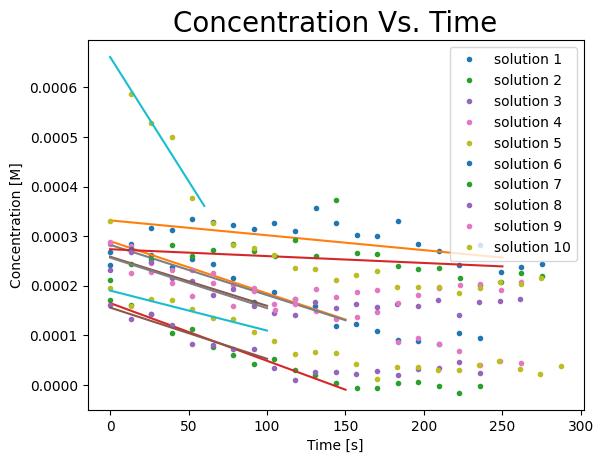

In [124]:
if os.getcwd() != mes_folder_3:
    os.chdir(mes_folder_3)
print("Current Directory:", os.getcwd())

solutions = [1,2,3,4,5,6,7,8,9,10] # replace with the solutions you want to use

# define I0
dark = get_data(r"dark.SSM")
I0 = get_data(r"blank.SSM")
I0['Intensity'] = I0['Intensity'] - dark['Intensity']

rates = []
reate_errs = []

for sol_num in solutions:
    sol_data = get_sol_data(sol_num, I0)
    # display(sol_data)
    sold_data_wavelength = get_sol_data_wavelength(sol_data, solutions_df.loc[sol_num]['total_time'], *waveeps)

    # get rate of reaction
    fit_interval = solutions_df.loc[sol_num]['fit_intervals'] # in seconds
    df_fit = sold_data_wavelength[sold_data_wavelength['time'] < fit_interval]

    if sol_num == 10:
        df_fit.drop([0], inplace=True)
    if sol_num == 6:
        df_fit.drop([0,1,2,3,4,5,6], inplace=True)

    fit = linear_fit(df_fit['time'], df_fit['concentration'])

    # save the rate of reaction
    rates.append(-fit[0][1])
    reate_errs.append(fit[1][1])

    # plot the Concentration Vs. time
    if True:
        name = ''
        if False: # diff figure
            name = '| solution ' + str(sol_num) 
        plt.plot(sold_data_wavelength['time'], sold_data_wavelength['concentration'], '.', label='solution ' + str(sol_num))
        t_show = np.linspace(0, fit_interval, 1000)
        plt.plot(t_show, linear_func(t_show, *fit[0]))
        plt.xlabel('Time [s]')
        plt.ylabel('Concentration [M]')
        plt.title('Concentration Vs. Time' + name, fontsize=20)
        plt.legend()
        if name != '':
            plt.show()

    
rates_DF = pd.DataFrame({'solution': solutions, 'rate [M/s]': rates, 'rate_err [M/s]': reate_errs})
rates_DF.index = rates_DF['solution']
display(rates_DF)


## Order for I2 (q)

$$
\log(rate) = q \cdot \log ([I_2]_{t=0}) + Const.
$$


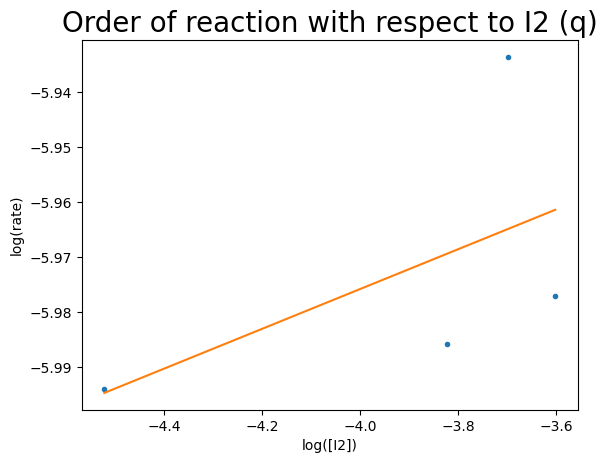

The order of the reaction with respect to I2 is q = 0.036 ± 0.038


In [125]:
I2_solutoins = [1,2,3,4] # replace with the solutions you want to use

x = np.log10(solutions_df.loc[I2_solutoins]['I2'])
y = np.log10(rates_DF.loc[I2_solutoins]['rate [M/s]'])

fit = linear_fit(x, y)

plt.plot(x, y, '.')
plt.plot(x, linear_func(x, *fit[0]))
plt.xlabel('log([I2])')
plt.ylabel('log(rate)')
plt.title('Order of reaction with respect to I2 (q)', fontsize=20)
plt.show()

q = fit[0][1]

print('The order of the reaction with respect to I2 is q = {:.3f} ± {:.3f}'.format(q, fit[1][1]))

## Order for Acetone (p)

$$
\log(rate) = p \cdot \log ([Ac]_{t=0}) + Const.
$$


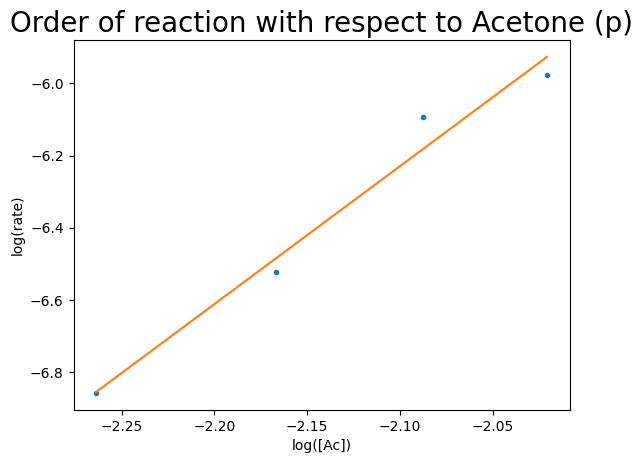

The order of the reaction with respect to Acetone is p = 3.822 ± 0.427


In [126]:
Ac_solutoins = [1,5,6,7] # replace with the solutions you want to use

x = np.log10(solutions_df.loc[Ac_solutoins]['acetone'])
y = np.log10(rates_DF.loc[Ac_solutoins]['rate [M/s]'])

fit = linear_fit(x, y)

plt.plot(x, y, '.')
plt.plot(x, linear_func(x, *fit[0]))
plt.xlabel('log([Ac])')
plt.ylabel('log(rate)')
plt.title('Order of reaction with respect to Acetone (p)', fontsize=20)
plt.show()

p = fit[0][1]

print('The order of the reaction with respect to Acetone is p = {:.3f} ± {:.3f}'.format(p, fit[1][1]))

## Order for Acid (r)

$$
\log(rate) = r \cdot \log ([H^+]_{t=0}) + Const.
$$


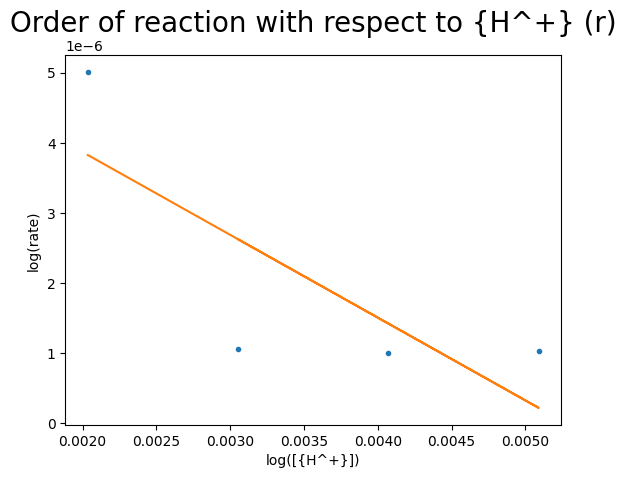

The order of the reaction with respect to H+ is r = -0.001 ± 0.001


In [127]:
H_solutoins = [1,8,9,10] # replace with the solutions you want to use

x = 1*(solutions_df.loc[H_solutoins]['HCl'])
y = 1*(rates_DF.loc[H_solutoins]['rate [M/s]'])

fit = linear_fit(x, y)

plt.plot(x, y, '.')
plt.plot(x, linear_func(x, *fit[0]))
plt.xlabel(r'log([{H^+}])')
plt.ylabel('log(rate)')
plt.title(r'Order of reaction with respect to {H^+} (r)', fontsize=20)
plt.show()

r = fit[0][1]

print('The order of the reaction with respect to H+ is r = {:.3f} ± {:.3f}'.format(r, fit[1][1]))

# Part 4 - rate constant for the reaction

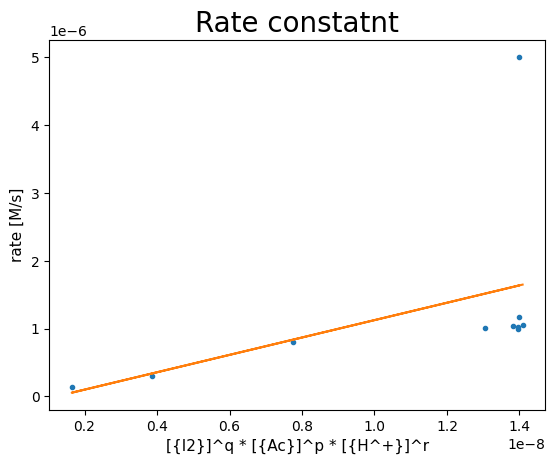

The rate constant is k = 1.282e+02 ± 8.997e+01


In [128]:
# p, q, r = 1, 0, 1

y = rates_DF['rate [M/s]']
x = solutions_df['I2']**q * solutions_df['acetone']**p * solutions_df['HCl']**r

fit = linear_fit(x, y)

plt.plot(x, y, '.')
plt.plot(x, linear_func(x, *fit[0]))
plt.xlabel(r'[{I2}]^q * [{Ac}]^p * [{H^+}]^r', fontsize=11)
plt.ylabel('rate [M/s]', fontsize=11)
plt.title('Rate constatnt', fontsize=20)
plt.show()

print('The rate constant is k = {:.3e} ± {:.3e}'.format(fit[0][1], fit[1][1]))